In [1]:
import awkward as ak
import numpy as np
import hist as hs
from coffea import processor, hist as chs
from coffea.nanoevents.methods import vector, candidate
from numba import jit

from coffea.nanoevents import BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt
from datetime import date
today = date.today()

plt.style.use(hep.style.CMS)

/uscms_data/d3/aaportel/micromamba/envs/analysis-env/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
class LLP_ntuple_processor(processor.ProcessorABC):
    """
    This class is used to process the ntuples created by the LLP ntuple producer.
    """
    
    
    def process(self, events):
        muoncut = abs(events.lepPdgId == 13)
        events['muonE'] = events.lepE[muoncut]
        events['muonPt'] = events.lepPt[muoncut]
        events['muonEta'] = events.lepEta[muoncut]
        events['muonPhi'] = events.lepPhi[muoncut]
        events['muonPdgId'] = events.lepPdgId[muoncut]
        events['muonDZ'] = events.lepDZ[muoncut]
        events['muonLooseId'] = events.lepLooseId[muoncut]
        events['muonTightId'] = events.lepTightId[muoncut]
        
        dataset = events.metadata['dataset']
        out = {
            dataset: {
                "entries": len(events),
            },
            'cuts': {},
            'vars': {},
        }
        
        cscCuts = {'no_cut': ak.values_astype(ak.ones_like(events.cscRechitClusterEta), 'bool')} #dummy truth vector of same shape as csc variables
        
        if events.metadata['dataset'] == 'signal':
            llp_acc_cut = (events.gLLP_csc == 1) 
            llp_eta_cut = abs(events.gLLP_eta) < 2
        if events.metadata['dataset'] == 'background':
            llp_acc_cut = ak.values_astype(ak.ones_like(events.metEENoise), 'bool') #just a dummy 1D truth vector
            llp_eta_cut = llp_acc_cut
            
        cscCuts['llp_acc_cut'] = llp_acc_cut
    
        cscCuts['csc_eff_cut'] = (events.nCscRechitClusters >= 1) 
        cscCuts['muon_acc_cut'] = (ak.count(events.muonPhi, axis=1) > 0) 
        cscCuts['met_cut'] = events.metEENoise >= 30 #event level
        cscCuts['muon_veto'] = (events.cscRechitClusterMuonVetoPt < 20) 
        cscCuts['jet_cut'] = (events.cscRechitClusterJetVetoPt < 10) 
        
        cscCuts['time_cut'] = ((events.cscRechitClusterTimeWeighted <= 12.5)&
                            (events.cscRechitClusterTimeWeighted >= -5  )) 
        
        cscCuts['ME11_veto'] = ((events.cscRechitClusterNRechitChamberPlus11 <= 0)&
                             (events.cscRechitClusterNRechitChamberMinus11 <= 0)) 
        
        cscCuts['ME12_veto'] = ((events.cscRechitClusterNRechitChamberPlus12 <= 0)&
                             (events.cscRechitClusterNRechitChamberMinus12 <= 0)) 
        
        cscCuts['re12_cut'] = (events.cscRechitCluster_match_RE12_0p4 == 0)
        cscCuts['mb1_cut'] = (events.cscRechitCluster_match_MB1Seg_0p4 == 0)
        cscCuts['rb1_cut'] = (events.cscRechitCluster_match_RB1_0p4 == 0)
        cscCuts['llp_eta_cut'] = llp_eta_cut
        cscCuts['time_spread_cut'] = (events.cscRechitClusterTimeSpreadWeightedAll <= 20)
        cscCuts['cls_eta_cut'] = (abs(events.cscRechitClusterEta) < 1.9)
        cscCuts['cls_size_cut'] = (events.cscRechitClusterSize > 100)
    
    
        cscCuts['cut_based'] = (((events.cscRechitClusterNStation10 > 1) & (abs(events.cscRechitClusterEta) < 1.9))|
                             ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 4) & (abs(events.cscRechitClusterEta) < 1.8))|
                             ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 3) & (abs(events.cscRechitClusterEta) < 1.6))|
                             ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 2) & (abs(events.cscRechitClusterEta) < 1.6))|
                             ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 1) & (abs(events.cscRechitClusterEta) < 1.1))
                            )

        cscCuts['dphi_cut'] = (abs(events.cscRechitClusterMetEENoise_dPhi) < 0.75)
        cscCuts['nrechits_cut'] = (events.cscRechitClusterSize > 130)
        
        _ = lambda x: x
        bins = 30
        cscVars = {
            'cscRechitClusterMetEENoise_dPhi':       [bins,    0,   5, _,  ],
            'cscRechitClusterTimeSpreadWeightedAll': [bins,    0,  20, _,  ],
            'cscRechitClusterTimeWeighted':          [bins, -5.5,  13, _,  ],
            #'cscRechitClusterSize':                  [bins,    0, 130, _,  ],
            'cscRechitClusterEta':                   [bins,    0,   4, abs,],
            'cscRechitClusterNStation10':            [bins,  -10,  10, _,  ],
            'cscRechitClusterAvgStation10':          [bins,  -10,  10, _,  ],
        }
        
        
        s = ''

        bigCut = cscCuts['no_cut']
        for var in cscVars:
            v = cscVars[var]
            out['vars'][var] = 1 #quick and dirty way of doing this
            
            for cut in cscCuts:
                out['cuts'][cut] = 1
                
                bigCut = bigCut & cscCuts[cut]
                
                data = ak.flatten(events[var][bigCut], axis=None)
                data = v[3](data)
                
                out[dataset][f'{var} with {cut}'] = hs.Hist.new.Reg(v[0], v[1], v[2], name=var, label=var).Double()
                out[dataset][f'{var} with {cut}'].fill(data)           
        
        
        
        return out   
    
    def postprocess(self, accumulator):
        return accumulator

In [8]:
date = today.strftime("%m_%d_%y")

fileset = {}
fileset['signal']     = ['root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v2/v3/normalized/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000_1pb_weighted.root',]
fileset['background'] = ['root://cmsxrootd.fnal.gov//store/user/christiw/displacedJetMuonAnalyzer/csc/V1p171/Data2018_UL/v3/normalized/ParkingBPH4_Run2018A_goodLumi.root']
out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=LLP_ntuple_processor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 4},
    #maxchunks = 1
)

cuts = list(out['cuts'].keys())
varnames = list(out['vars'].keys())

Output()

In [9]:
from hist.intervals import ratio_uncertainty
def ratio(num, den, ax):
    ax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view()),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    return ax

var: cscRechitClusterMetEENoise_dPhi with cut: no_cut saved in a pdf
var: cscRechitClusterMetEENoise_dPhi with cut: llp_acc_cut saved in a pdf
var: cscRechitClusterMetEENoise_dPhi with cut: csc_eff_cut saved in a pdf
var: cscRechitClusterMetEENoise_dPhi with cut: muon_acc_cut saved in a pdf
var: cscRechitClusterMetEENoise_dPhi with cut: met_cut saved in a pdf
var: cscRechitClusterMetEENoise_dPhi with cut: muon_veto saved in a pdf
var: cscRechitClusterMetEENoise_dPhi with cut: jet_cut saved in a pdf
var: cscRechitClusterMetEENoise_dPhi with cut: time_cut saved in a pdf
var: cscRechitClusterMetEENoise_dPhi with cut: ME11_veto saved in a pdf
var: cscRechitClusterMetEENoise_dPhi with cut: ME12_veto saved in a pdf
var: cscRechitClusterMetEENoise_dPhi with cut: re12_cut saved in a pdf
var: cscRechitClusterMetEENoise_dPhi with cut: mb1_cut saved in a pdf
var: cscRechitClusterMetEENoise_dPhi with cut: rb1_cut saved in a pdf
var: cscRechitClusterMetEENoise_dPhi with cut: llp_eta_cut saved in a 

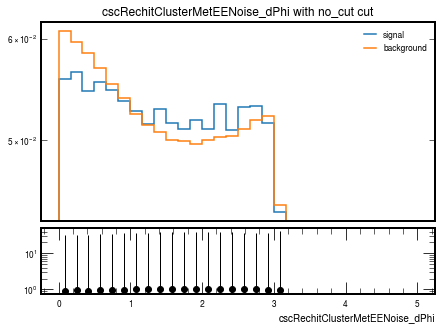

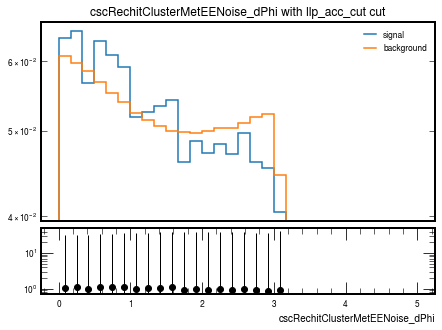

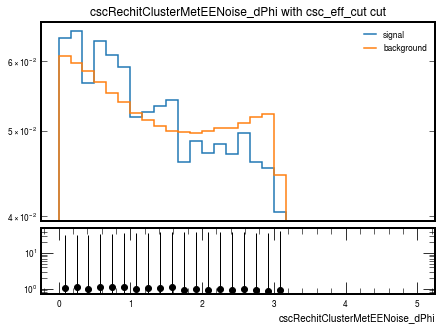

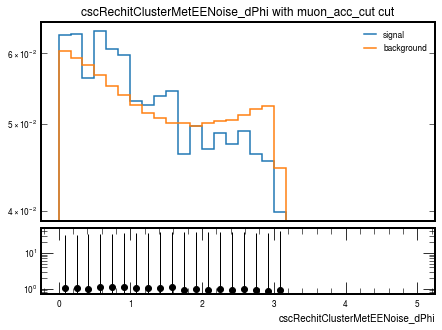

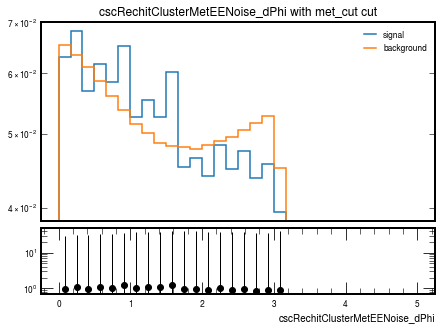

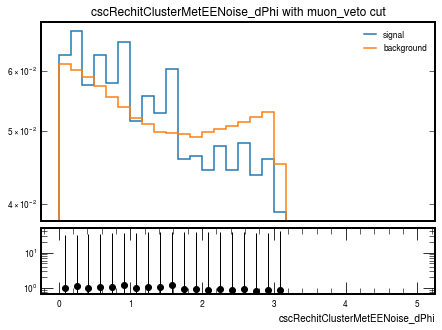

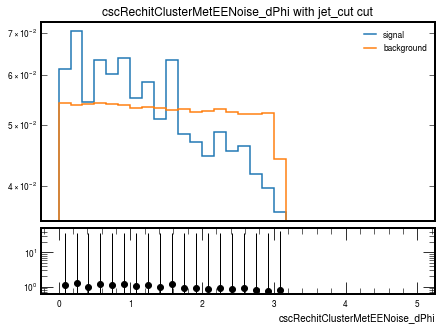

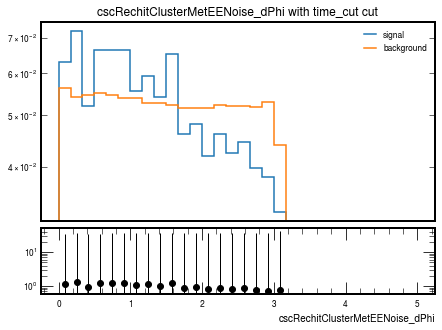

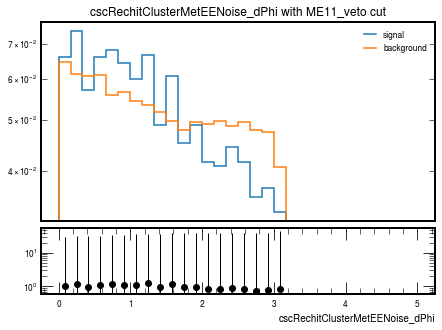

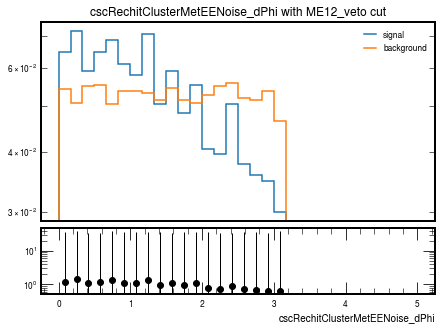

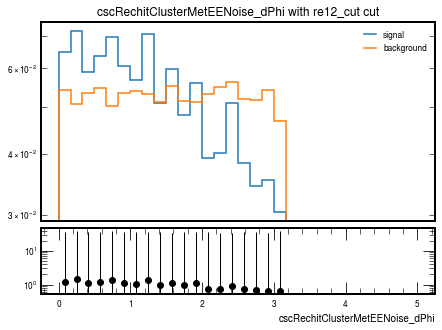

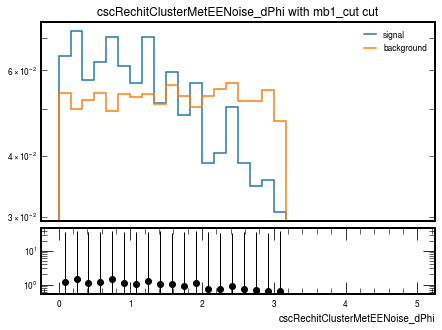

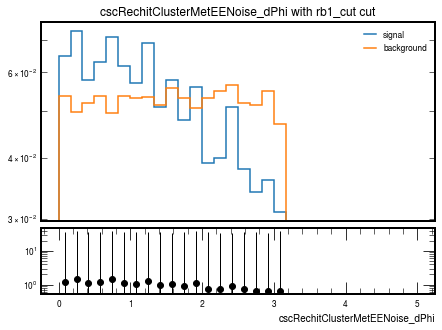

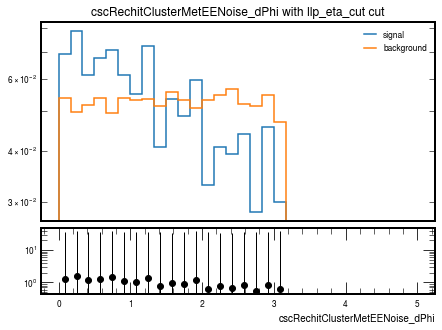

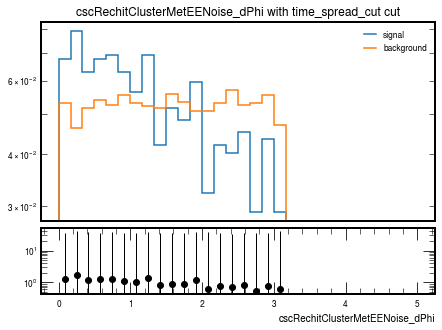

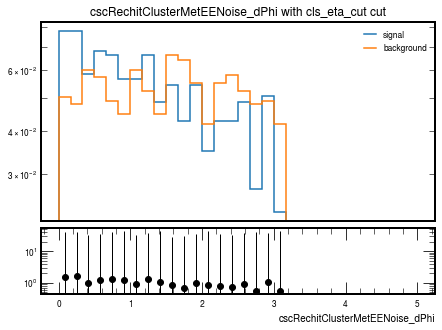

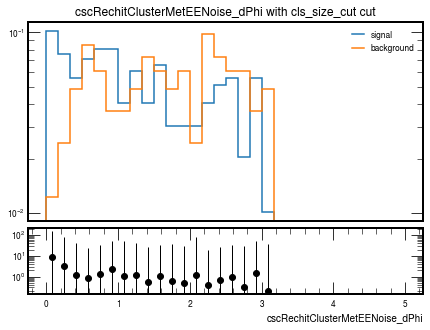

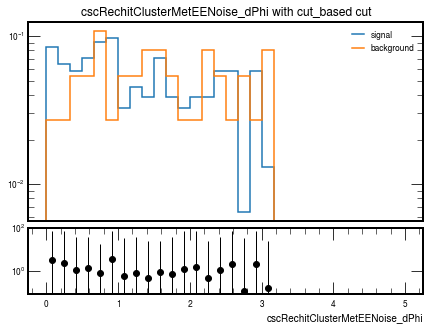

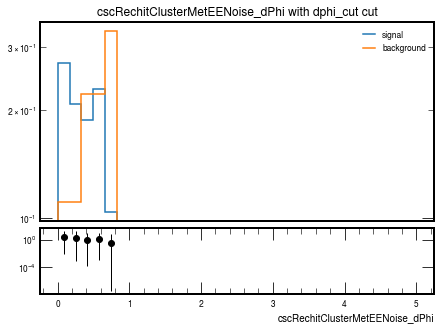

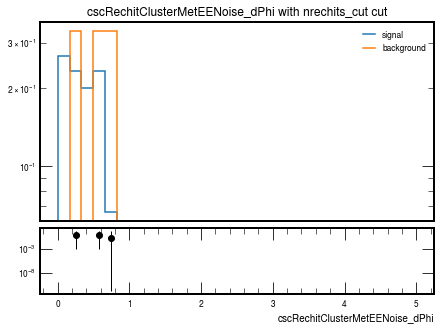

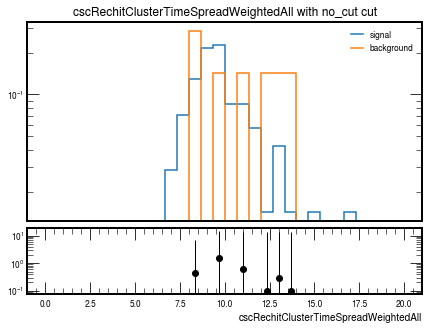

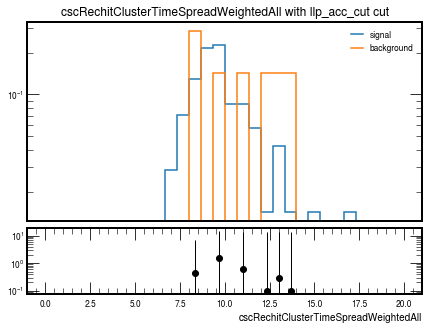

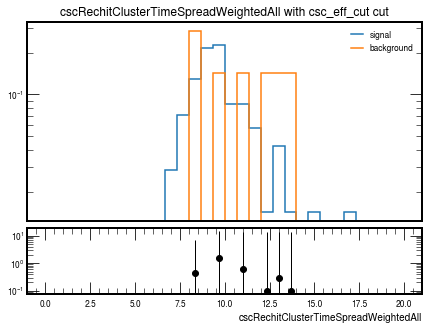

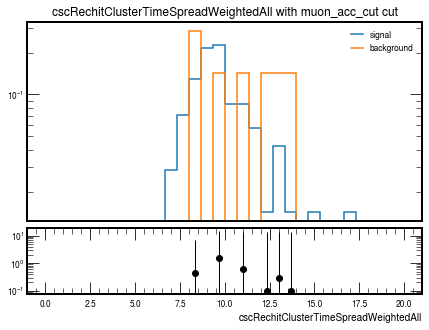

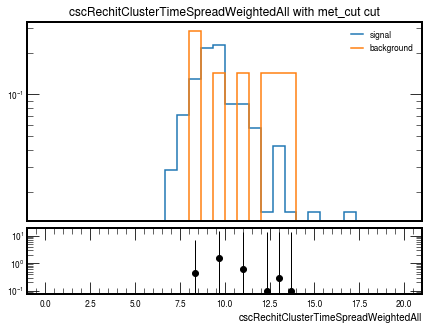

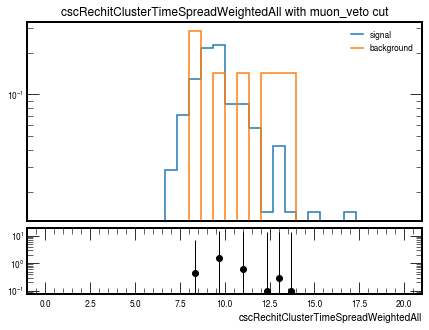

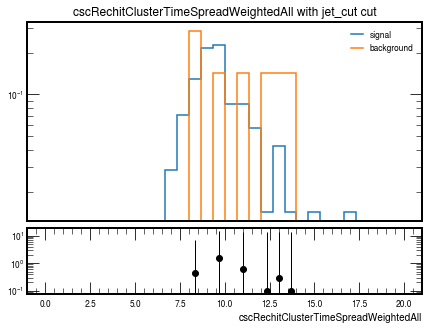

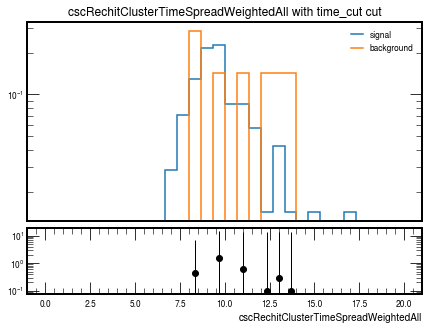

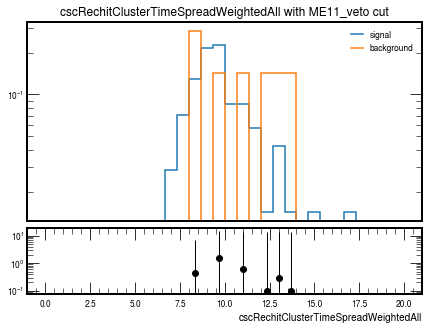

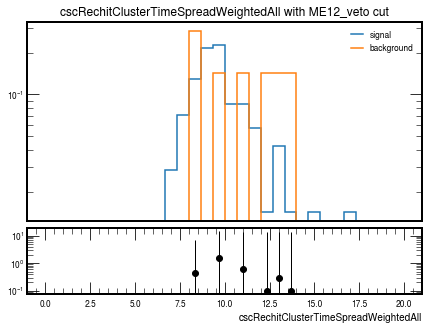

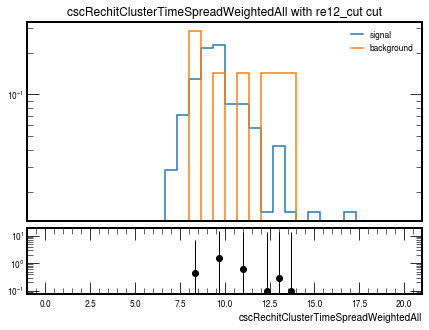

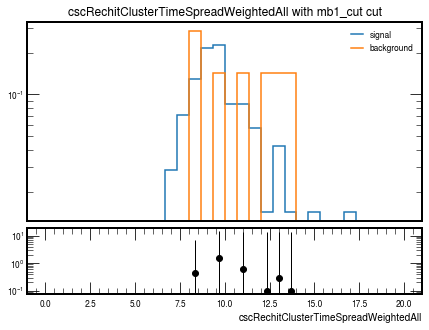

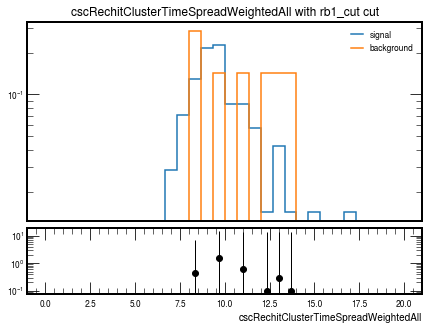

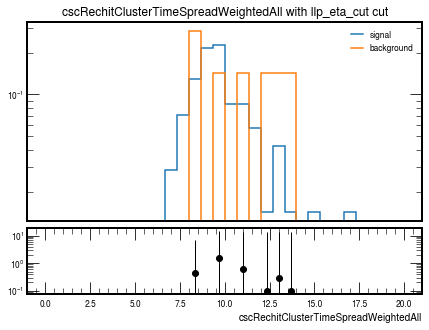

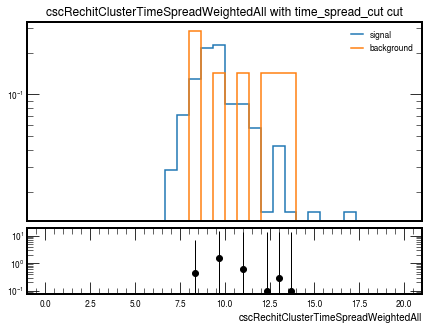

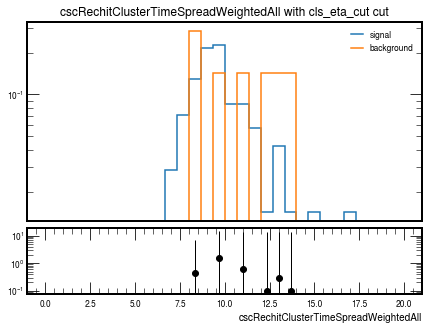

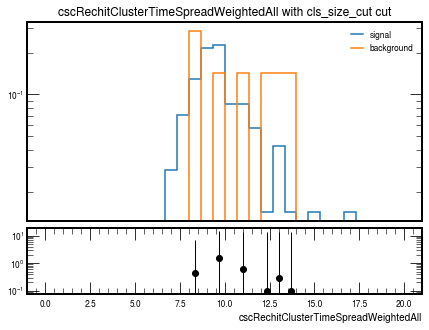

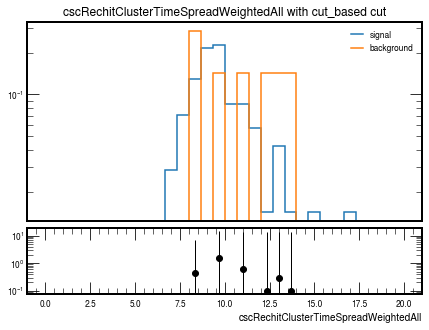

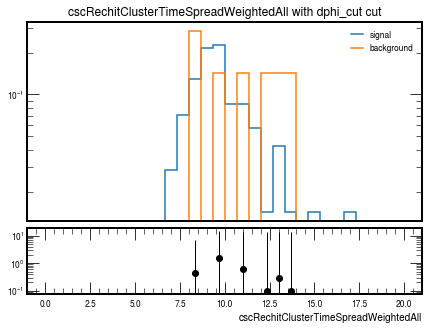

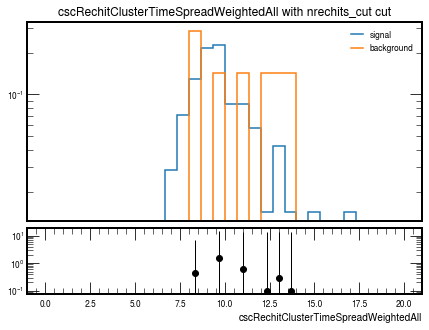

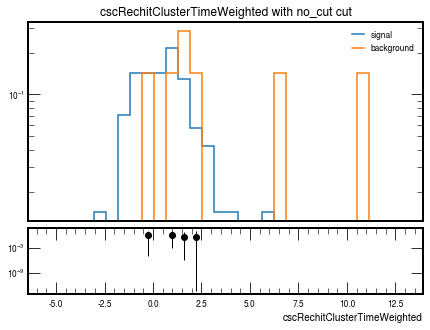

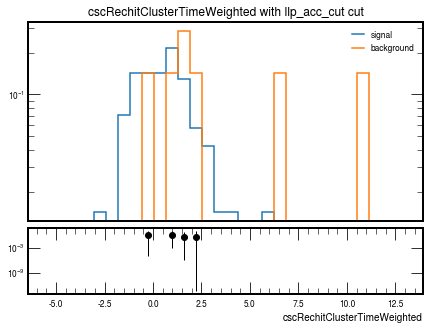

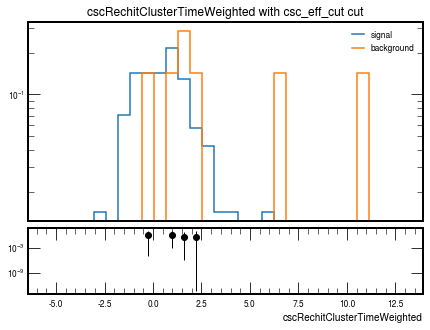

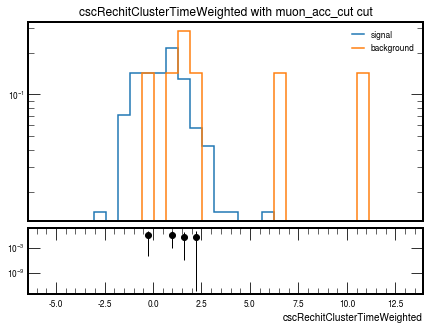

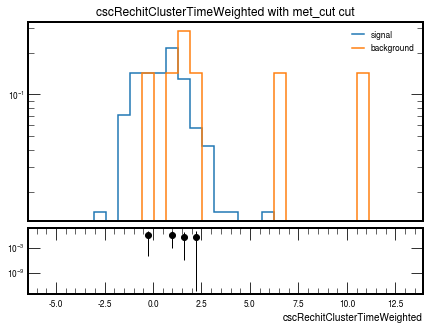

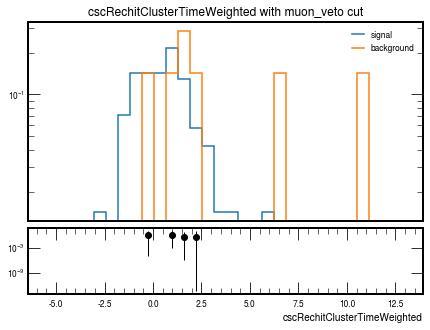

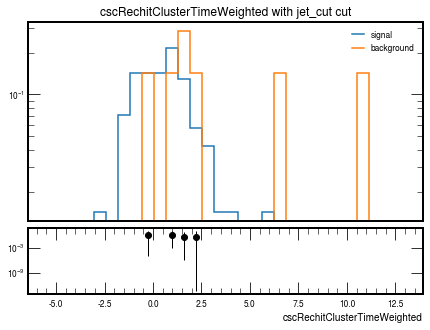

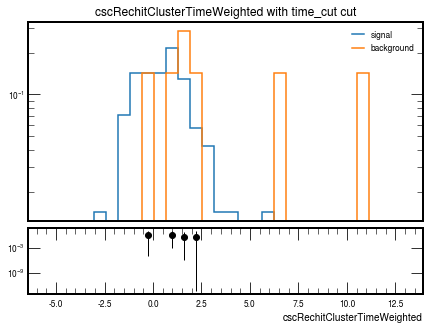

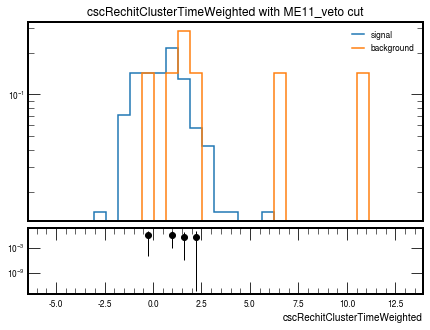

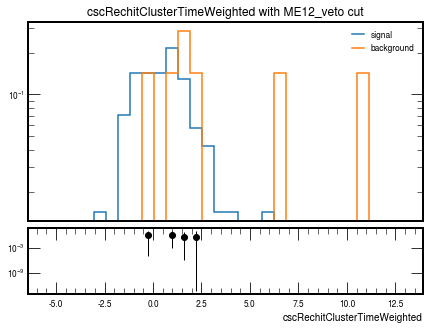

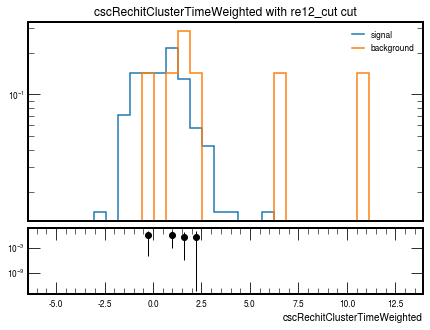

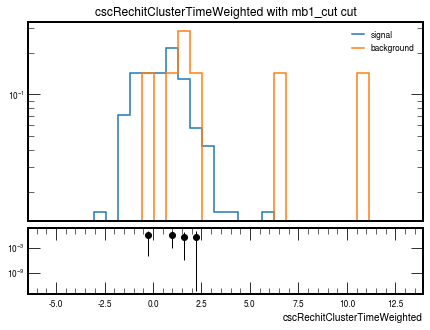

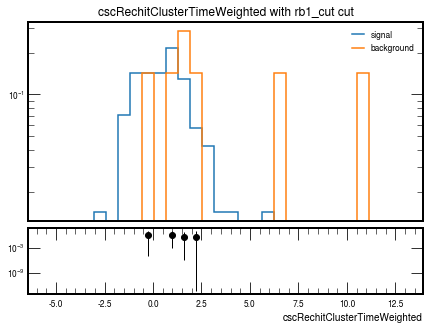

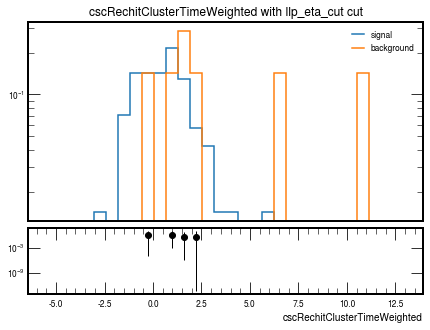

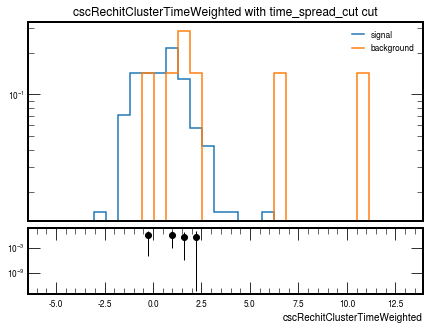

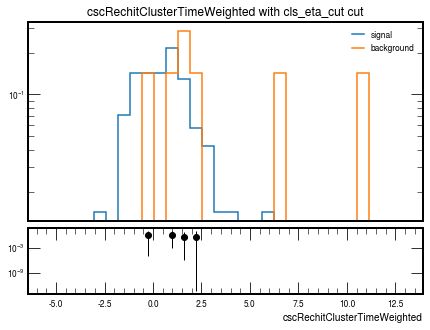

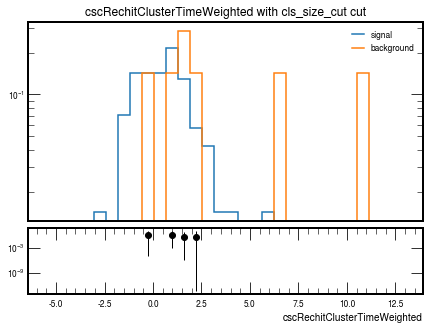

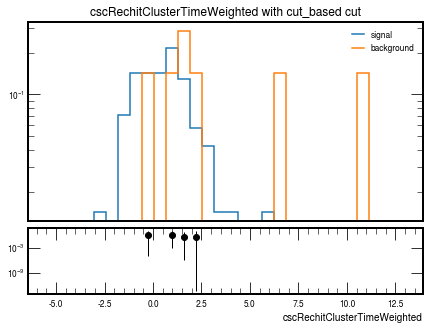

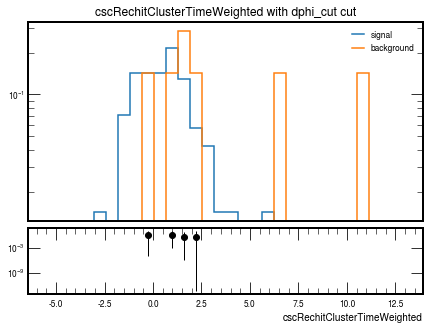

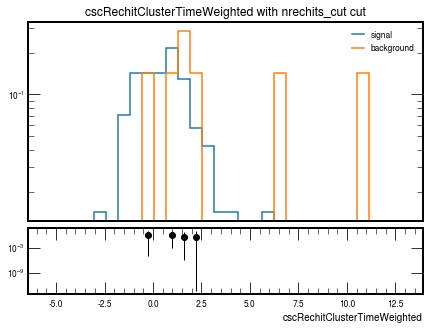

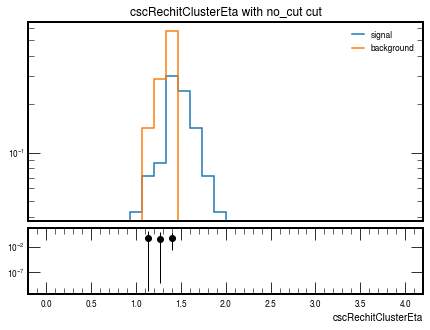

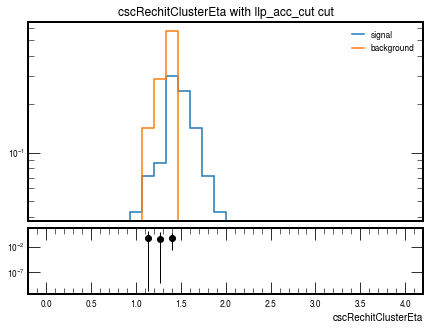

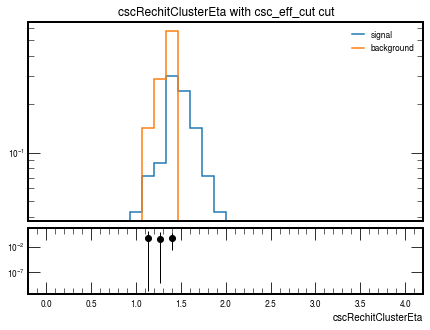

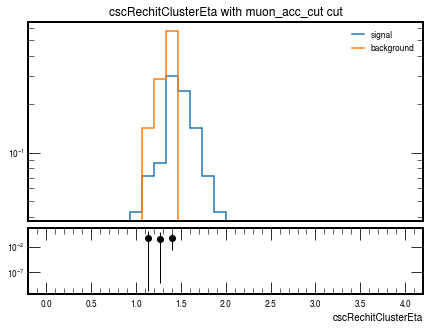

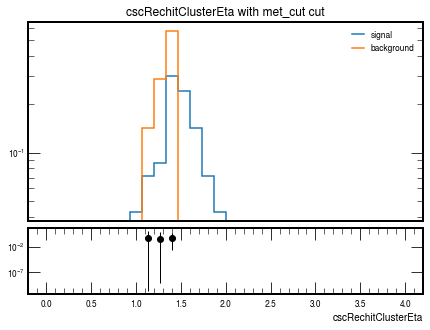

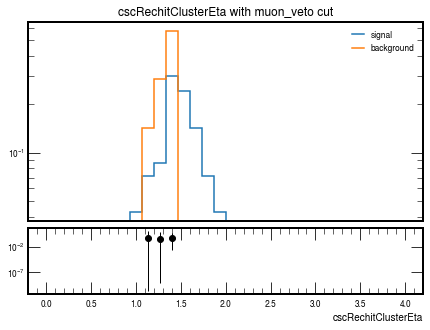

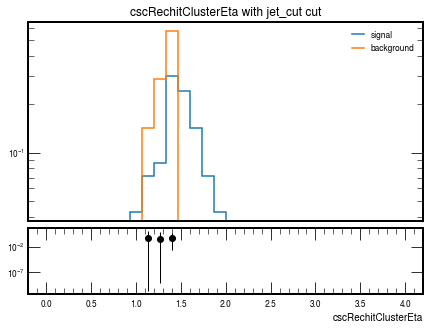

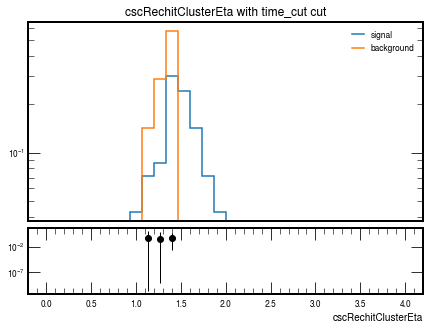

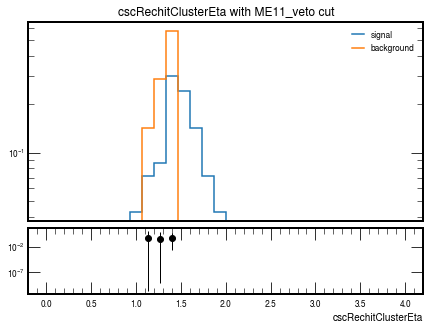

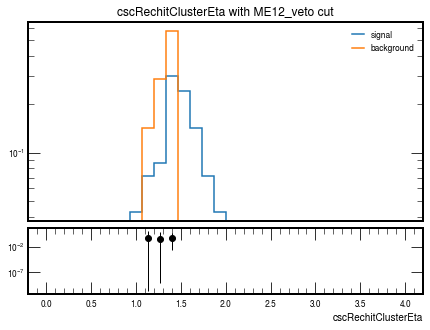

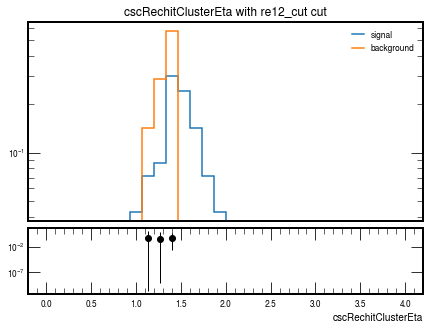

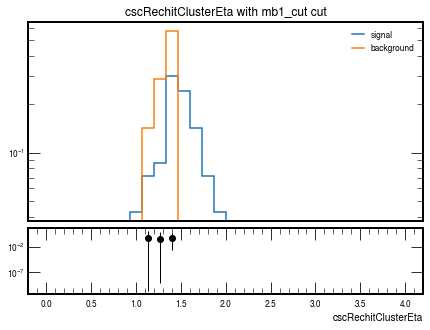

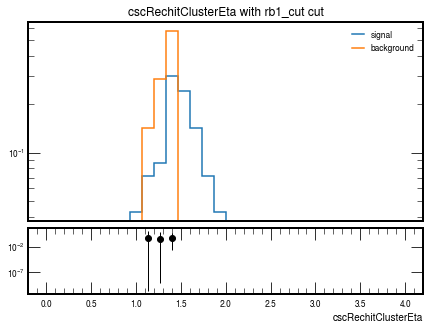

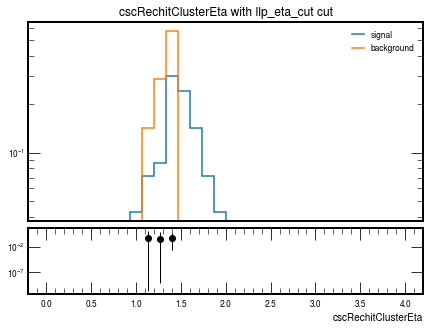

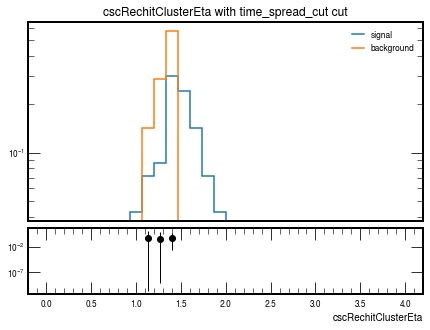

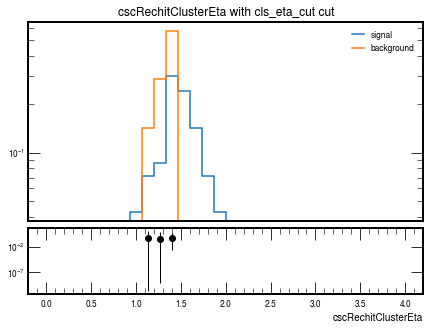

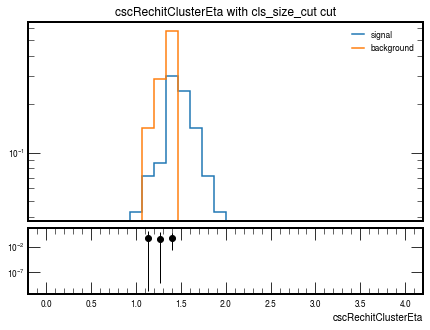

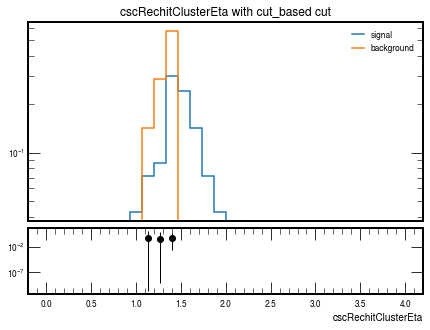

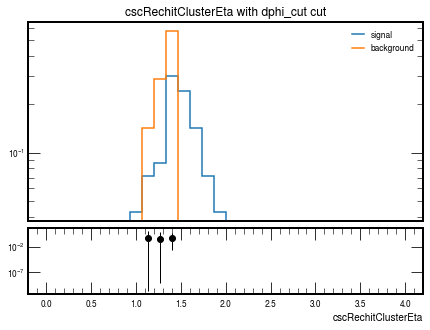

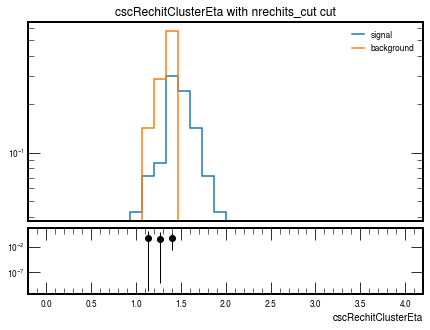

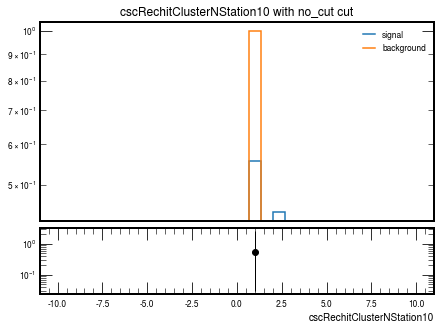

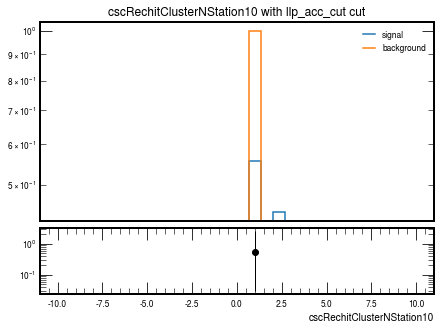

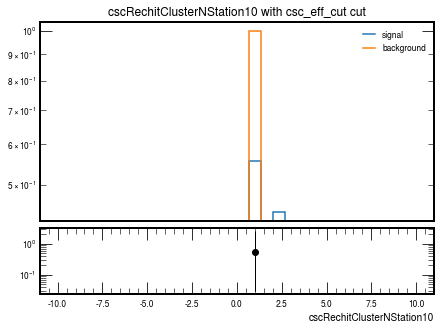

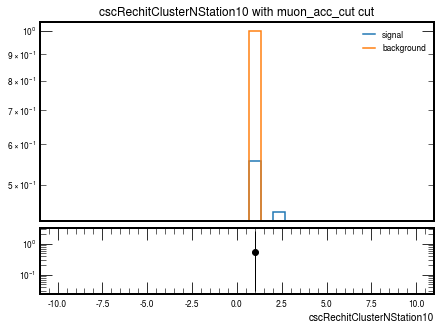

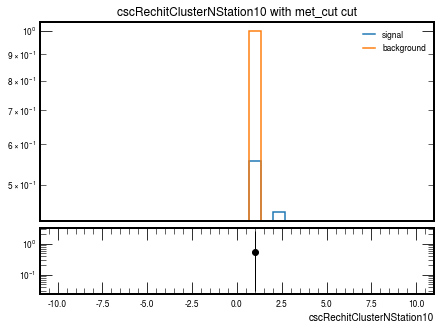

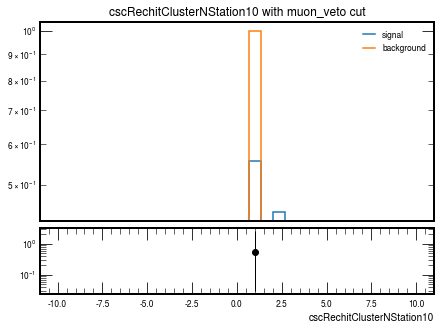

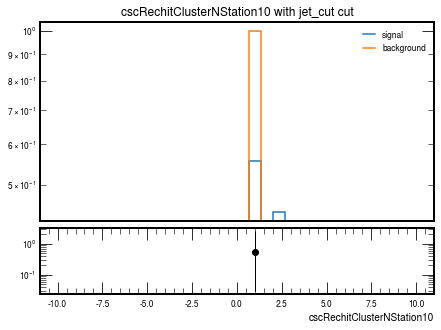

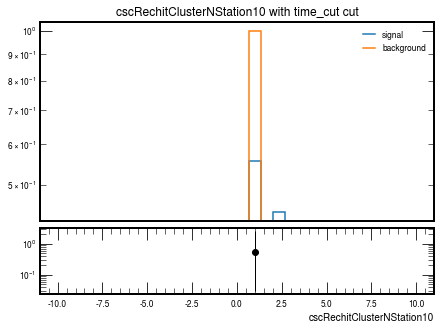

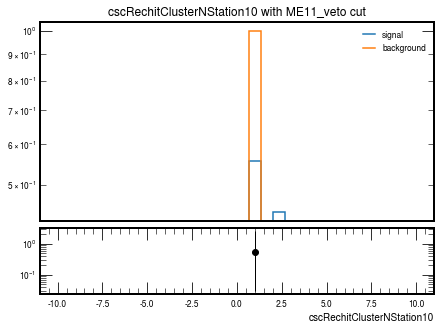

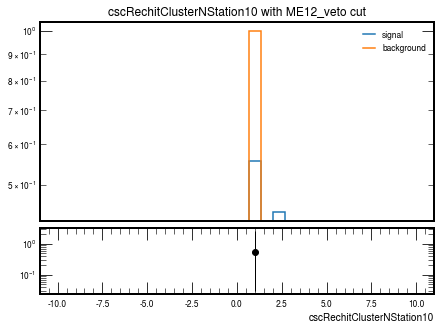

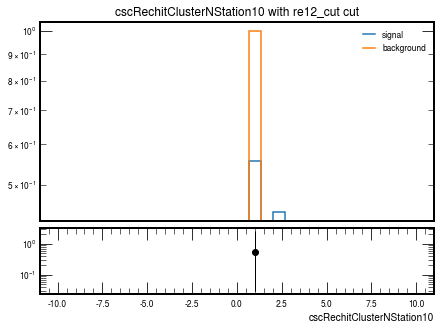

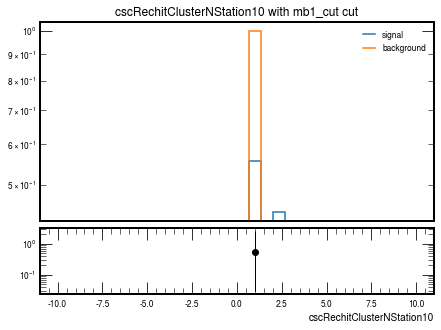

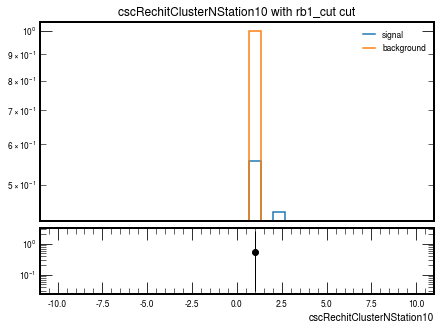

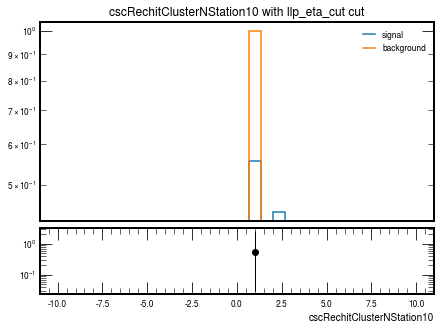

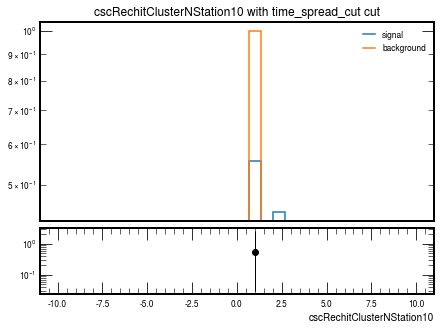

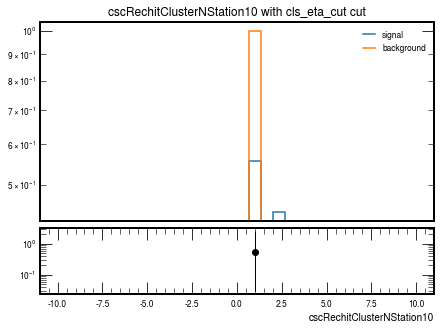

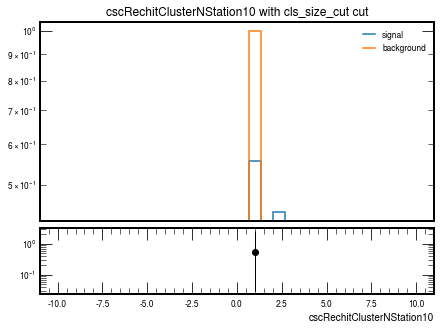

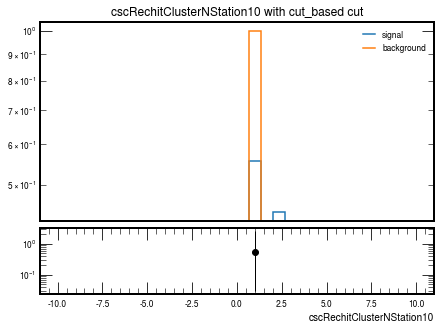

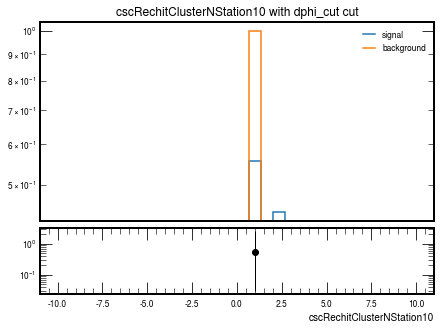

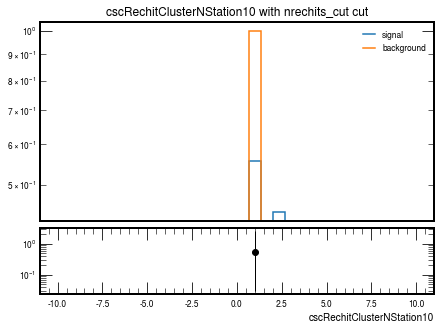

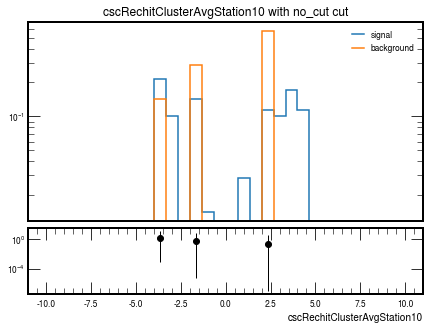

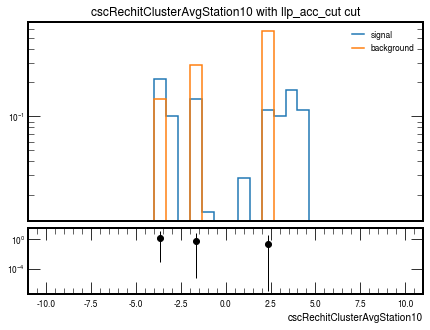

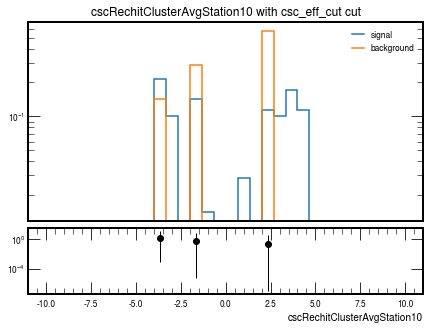

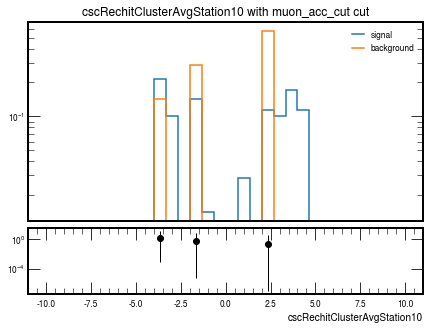

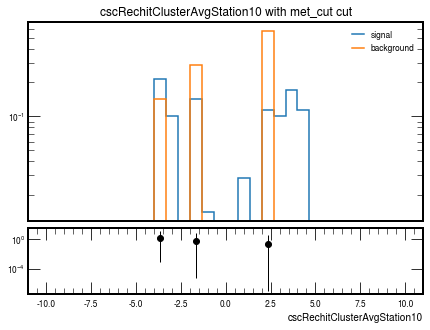

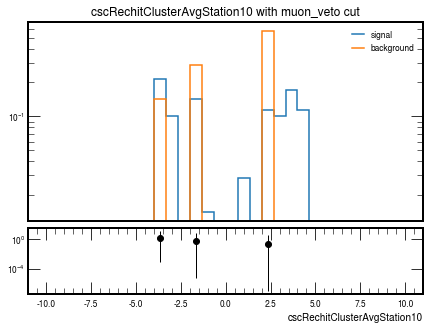

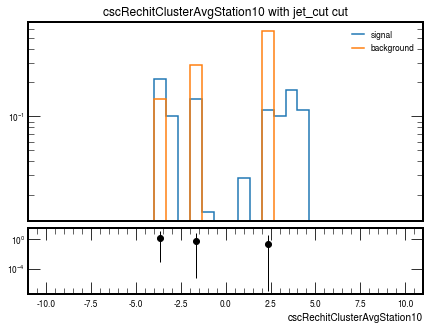

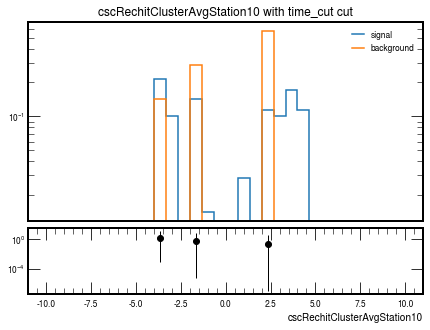

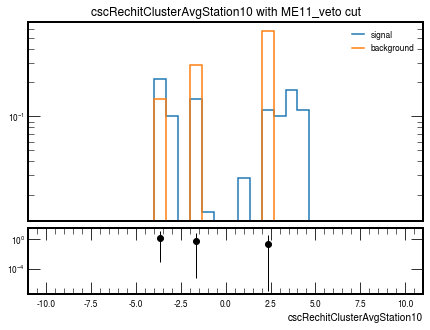

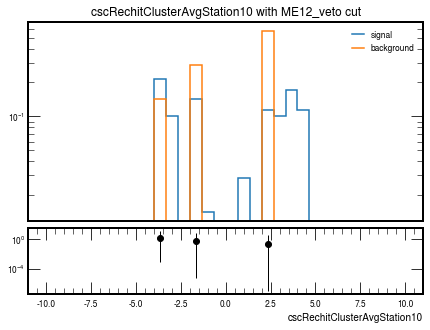

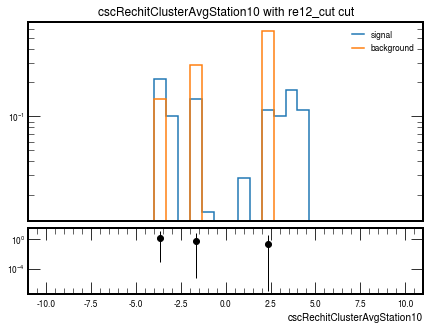

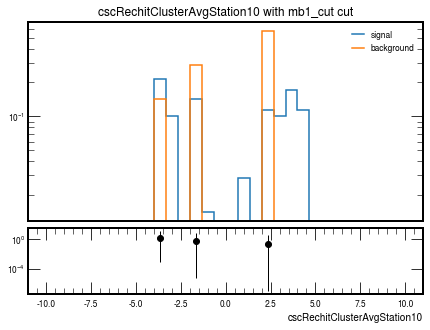

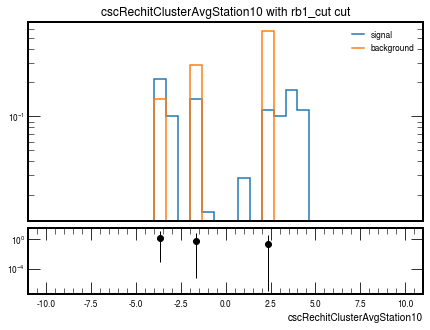

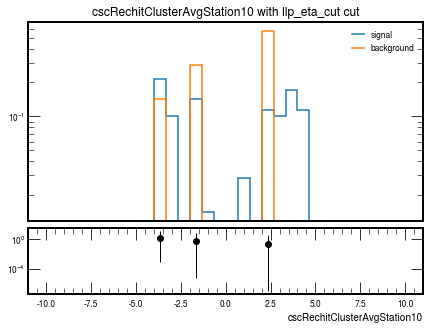

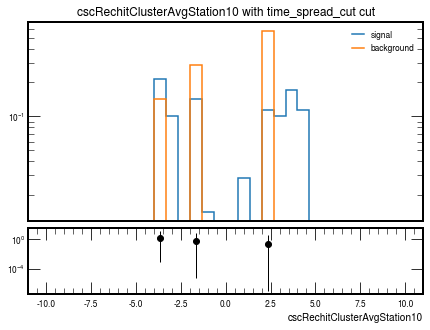

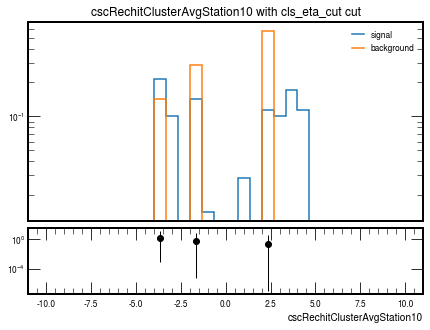

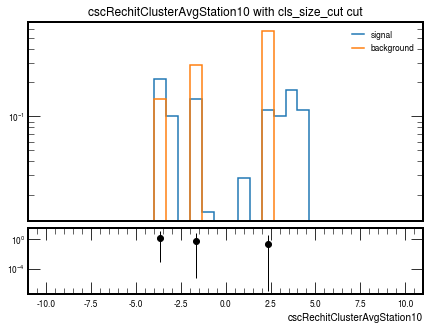

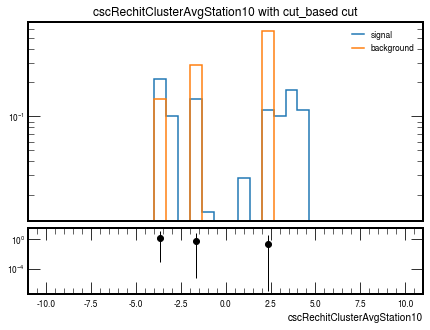

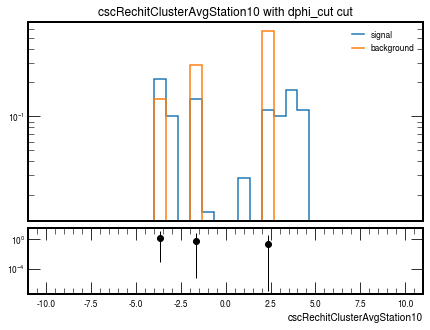

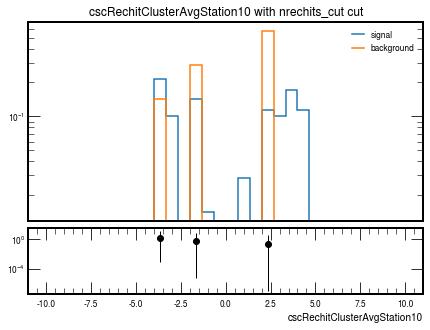

In [10]:
from matplotlib.backends.backend_pdf import PdfPages
import warnings

with warnings.catch_warnings(): #i don't need to see all the divide by zero warnings
    warnings.simplefilter("ignore")

    for varname in varnames:
        pdf = PdfPages(f'varPlots_sb_clsCuts_{date}/{varname}_cutflow_sb.pdf')

        for cut in cuts:
            fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(np.sqrt(2)*5,5))

            signal = out['signal'][f'var: {varname} with cut: {cut}']
            background = out['background'][f'var: {varname} with cut: {cut}']

            hep.histplot(signal/signal.sum(), label='signal', ax=ax[0])
            hep.histplot(background/background.sum(), label='background', ax=ax[0])
            ax[0].set_title(f'{varname} with {cut} cut')
            ax[0].legend()
            ax[0].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            ax[0].set(xlabel=None)
            ax[0].set_yscale('log')

            ratio(signal/signal.sum(), background/background.sum(), ax[1])
            ax[1].set_xlim(ax[0].get_xlim())
            ax[1].set(xlabel=varname)
            ax[1].set_yscale('log')
            fig.subplots_adjust(wspace=0, hspace=.05)
            pdf.savefig(fig)
            print(f'var: {varname} with cut: {cut} saved in a pdf')
        pdf.close()
